In [153]:
import numpy as np
import pandas as pd
import skimage.io as sio
import matplotlib.pyplot as plt
import skimage
from skimage.morphology import square, opening, closing, skeletonize
from skimage.measure import regionprops, label
from skan import csr, draw

import diff_classifier.aws as aws
import diff_register.register as reg
import diff_register.im_process as imp

In [3]:
imprefix = 'mGluR5326_5_Iba1488_slice3_10x_scan'
folder = 'I:/Mengying/Confocal/20181018 mGluR5326 328 QD in vivo'
imfilename = '{}/{}.tif'.format(folder, imprefix)
#aws.download_s3('{}/{}'.format(folder, imfilename), imfilename, bucket_name='ccurtis.data')

In [4]:
imfilename

'I:/Mengying/Confocal/20181018 mGluR5326 328 QD in vivo/mGluR5326_5_Iba1488_slice3_10x_scan.tif'

In [11]:
rawim = sio.imread(imfilename)

In [36]:
rawim.shape

(2, 1973, 2457)

In [68]:
cellim = rawim[0, :, :]
qdotim = rawim[1, :, :]
invim = (256**2 - cellim[xr[0]:xr[1], yr[0]:yr[1]]).astype('uint16')

In [185]:
sio.imsave('large_image.tif', cellim)

c:\users\enuser\anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: large_image.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


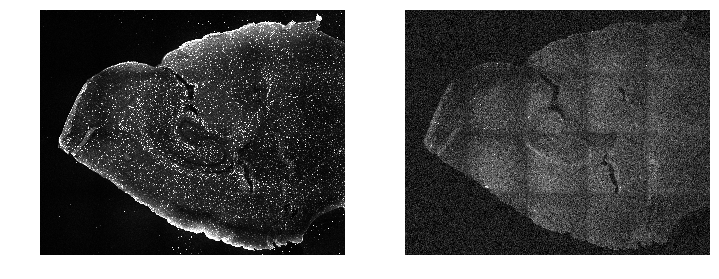

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(12,12))
axes[0].imshow(cellim, cmap='gray', vmax=5*cellim.mean())
axes[1].imshow(qdotim, cmap='gray', vmax=5*qdotim.mean())
for ax in axes:
    ax.axis('off')

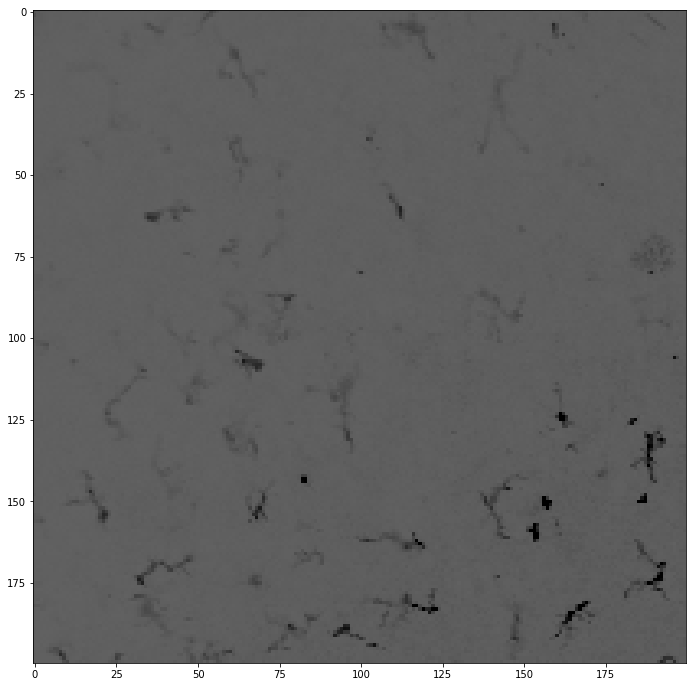

In [84]:
fig, axes = plt.subplots(ncols=1, figsize=(12,12))
axes.imshow(invim, cmap='gray', vmax=1.1*invim.mean())

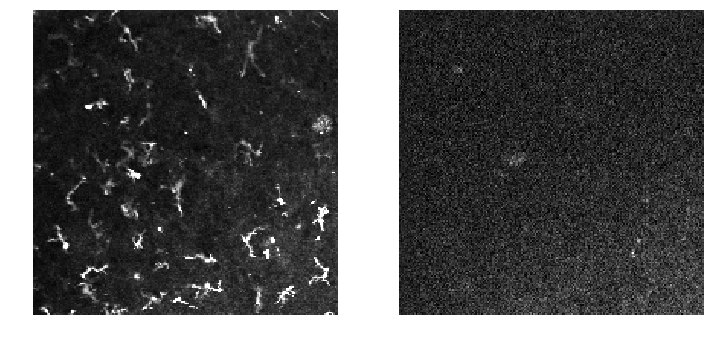

In [32]:
xr = (500,700)
yr = (500,700)
fig, axes = plt.subplots(ncols=2, figsize=(12,12))
axes[0].imshow(cellim[xr[0]:xr[1], yr[0]:yr[1]], cmap='gray', vmax=4*cellim.mean())
axes[1].imshow(qdotim[xr[0]:xr[1], yr[0]:yr[1]], cmap='gray', vmax=5*qdotim.mean())
for ax in axes:
    ax.axis('off')

In [85]:
sio.imsave('small_image.tif', cellim[xr[0]:xr[1], yr[0]:yr[1]])

c:\users\enuser\anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: small_image.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [66]:
(256**2 - cellim[xr[0]:xr[1], yr[0]:yr[1]]).astype('uint16')

array([[64855, 65011, 65190, ..., 65101, 65190, 65205],
       [64597, 65011, 65102, ..., 65169, 65220, 65202],
       [64948, 65095, 65104, ..., 65217, 65181, 65165],
       ...,
       [65297, 65314, 65332, ..., 65244, 65107, 65126],
       [65331, 65322, 65323, ..., 65052, 65195, 65211],
       [65335, 65329, 65307, ..., 64897, 65244, 65237]], dtype=uint16)

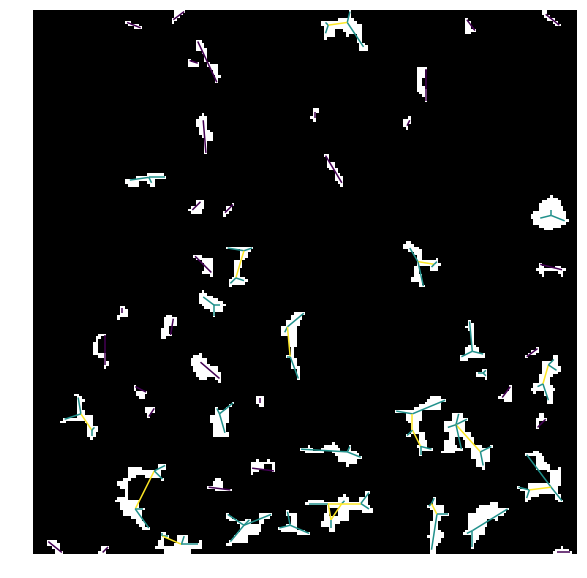

In [184]:
skel = imp.skeleton_image('.', 'small_image.tif', 1.6*cellim.mean(), area_thresh=8, show=True, imname='skel_small.tif',
                          tofilt=False, close=True, ajar=False, channel=None, figsize=(10,10))

In [178]:
Dfeatures = imp.mglia_features(skel)

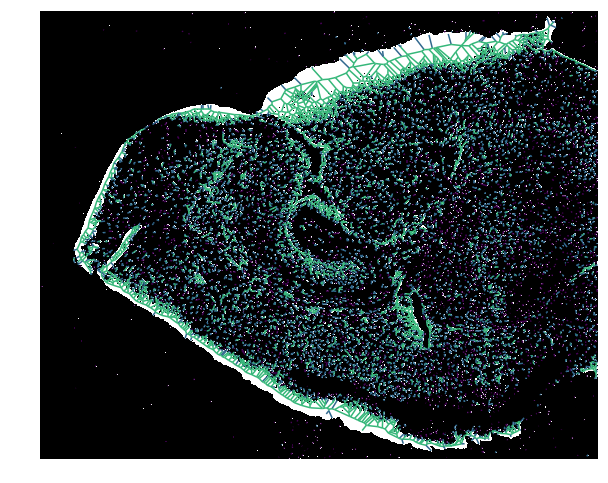

In [186]:
skel = imp.skeleton_image('.', 'large_image.tif', 1.6*cellim.mean(), area_thresh=8, show=True, imname='skel_small.tif',
                          tofilt=False, close=True, ajar=False, channel=None, figsize=(10,10))

In [189]:
Dfeatures = mglia_features(skel)

In [188]:
def mglia_features(skeleton, umppx=1):
    """Assembles feature dataset from pre-processed cellular images

    Parameters
    ----------
    props : skimage.object
        Contains raw properties from input cell image. Output from
        im_process.skeleton_image
    branch_data_short : blank
        Data from skeletonized cells. Output from im_process.skeleton_image
    convert : bool
        If True, converts from pixels to microns using umppx
    umppx : int or float
        Conversion ratio from pixels to microns

    Returns
    -------
    features : pandas.core.frames.DataFrame
        Pandas dataframe of cellular features

    Notes
    -----
    Raises error if skeleton is missing from any cell in the binary image.

    """
    props = skeleton.props
    branch_data_short = skeleton.branchdat
    X = np.zeros((len(props)))
    Y = np.zeros((len(props)))
    perimeter = np.zeros((len(props)))
    areas = np.zeros((len(props)))
    eccentricity = np.zeros((len(props)))
    inertia_tensor = [0]*len(props)
    label = [0]*len(props)
    max_intensity = np.zeros((len(props)))
    mean_intensity = np.zeros((len(props)))
    moments = [0]*len(props)
    solidity = np.zeros((len(props)))
    # total_processes = np.zeros((len(props)))
    # avg_p_length = np.zeros((len(props)))
    # main_process = np.zeros((len(props)))

    # properties that can be found from sklearn.measure.regionprops
    counter = 0
    for item in props:
        X[counter] = item.centroid[0]
        Y[counter] = item.centroid[1]
        perimeter[counter] = item.perimeter
        areas[counter] = item.area
        eccentricity[counter] = item.eccentricity
        inertia_tensor[counter] = item.inertia_tensor
        label[counter] = item.label
        # max_intensity[counter] = item.max_intensity
        # mean_intensity[counter] = item.mean_intensity
        moments[counter] = item.moments
        solidity[counter] = item.solidity
        counter = counter + 1

    # properties associated with processes as found from skan
    mglia = branch_data_short['skeleton-id'].max()
    nbranches = []
    avg_p_length = []
    main_process = []

    xs = []
    ys = []

    ncount = 0
    for i in branch_data_short['skeleton-id'].unique():
        bcount = branch_data_short[branch_data_short[
                                   'skeleton-id'] == i]['skeleton-id'].count()
        bavg = np.mean(branch_data_short[
                       branch_data_short['skeleton-id'] == i][
                       'branch-distance'])
        blong = np.max(branch_data_short[
                       branch_data_short['skeleton-id'] == i][
                       'branch-distance'])
        xcoord = np.mean([np.mean(
                         branch_data_short[branch_data_short[
                          'skeleton-id'] == i]['img-coord-0-0']),
                         np.mean(branch_data_short[
                          branch_data_short['skeleton-id'] == i][
                          'img-coord-1-0'])])
        xs.append(xcoord)
        ycoord = np.mean([np.mean(branch_data_short[
                         branch_data_short['skeleton-id'] == i][
                         'img-coord-0-1']),
                         np.mean(branch_data_short[
                          branch_data_short['skeleton-id'] == i][
                          'img-coord-1-1'])])
        ys.append(ycoord)
        nbranches.append(bcount)
        avg_p_length.append(bavg)
        main_process.append(blong)

    nbranches_ord = [0]*len(nbranches)
    avg_p_length_ord = [0]*len(nbranches)
    main_process_ord = [0]*len(nbranches)

    for i in range(0, len(xs)):
        # print(i, xs[i], ys[i])
        skel_id = i
        min_function = np.square(xs[i] - X)+np.square(ys[i] - Y)
        try:
            mglia_id = np.argmin(min_function)
            nbranches_ord[mglia_id] = nbranches[skel_id]
        except IndexError:
            mglia_ids = np.argsort(min_function)
            for idd in mglia_ids:
                if idd < len(nbranches):
                    mglia_id = idd
                    break
            nbranches_ord[mglia_id] = nbranches[skel_id
                                                ] + nbranches_ord[mglia_id]
        avg_p_length_ord[mglia_id] = avg_p_length[skel_id
                                                  ] + avg_p_length_ord[mglia_id]
        main_process_ord[mglia_id] = main_process[skel_id
                                                  ] + main_process_ord[mglia_id]
        # print(mglia_id)
        # print(np.min(min_function))

    factor = umppx
    features = pd.DataFrame({'X': X*factor,
                             'Y': Y*factor,
                             'perimeter': perimeter*factor,
                             'area': areas*factor*factor,
                             'eccentricity': eccentricity,
                             'inertia_tensor': inertia_tensor,
                             'label': label,
                             # 'max intensity' : max_intensity,
                             # 'mean intensity' : mean_intensity,
                             'moments': moments,
                             'solidity': solidity,
                             #'total_branches': nbranches_ord,
                             #'average_branch': [x*factor for x in avg_p_length_ord],
                             #'main_branch': [x*factor for x in main_process_ord]
                             })

    return features

In [190]:
Dfeatures

,X,Y,area,eccentricity,inertia_tensor,label,moments,perimeter,solidity
0,6.642857,1297.035714,28.0,0.878135,"[[1.2487244897959184, -0.7270408163265306], [-...",2,"[[28.0, 102.0, 502.0, 2766.0], [57.0, 228.0, 1...",19.071068,0.903226
1,8.818182,2020.181818,11.0,0.269680,"[[0.8760330578512397, -0.033057851239669415], ...",9,"[[11.0, 20.0, 46.0, 116.0], [13.0, 24.0, 54.0,...",9.656854,1.000000
2,10.000000,902.125000,16.0,0.735980,"[[0.859375, -0.0], [-0.0, 1.875]]",11,"[[16.0, 32.0, 94.0, 308.0], [18.0, 36.0, 102.0...",12.828427,0.941176
3,11.652174,2340.956522,23.0,0.834681,"[[3.3459357277882793, 0.6672967863894138], [0....",12,"[[23.0, 38.0, 92.0, 254.0], [68.0, 97.0, 235.0...",17.242641,0.884615
4,14.190476,671.190476,21.0,0.624692,"[[2.3446712018140583, 0.17913832199546484], [0...",13,"[[21.0, 46.0, 132.0, 442.0], [46.0, 97.0, 263....",16.071068,0.875000
5,17.545455,2186.909091,11.0,0.818181,"[[0.8099173553719008, -0.4132231404958677], [-...",20,"[[11.0, 28.0, 92.0, 328.0], [10.0, 30.0, 110.0...",9.207107,0.733333
6,22.250000,2448.750000,8.0,0.738426,"[[0.9375, -0.0625], [-0.0625, 0.4375]]",28,"[[8.0, 10.0, 16.0, 28.0], [14.0, 18.0, 30.0, 5...",7.828427,0.888889
7,27.214286,1439.857143,14.0,0.918203,"[[0.9795918367346937, 1.0408163265306123], [1....",33,"[[14.0, 45.0, 187.0, 855.0], [26.0, 69.0, 241....",13.242641,0.823529
8,29.600000,2185.666667,15.0,0.761599,"[[1.1555555555555552, -0.46666666666666673], [...",42,"[[15.0, 39.0, 133.0, 513.0], [25.0, 72.0, 240....",12.828427,0.833333
9,29.368421,2429.684211,19.0,0.859296,"[[2.531855955678671, -1.1163434903047091], [-1...",43,"[[19.0, 45.0, 137.0, 453.0], [51.0, 142.0, 456...",16.278175,0.863636


In [191]:
Dfeatures.area.mean()

116.03410954411282

In [194]:
Dfeatures.area.count()

6098